In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 64
lr = 0.0002
z_dim = 100
epochs = 101
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = DataLoader(
    datasets.MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

# Generator Network
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize networks
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

# Optimizers and loss
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr)
opt_D = optim.Adam(D.parameters(), lr=lr)

# Lists to store losses
losses_G = []
losses_D = []

# Store sample image 
sample_epochs = [0, 50, 100]
sample_images = {}

# Training loop
for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z)

        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())
        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z)
        D_fake = D(fake_imgs)
        loss_G = criterion(D_fake, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    if epoch in sample_epochs:
        with torch.no_grad():
            z = torch.randn(64, z_dim).to(device)
            generated = G(z).cpu()
            sample_images[epoch] = generated



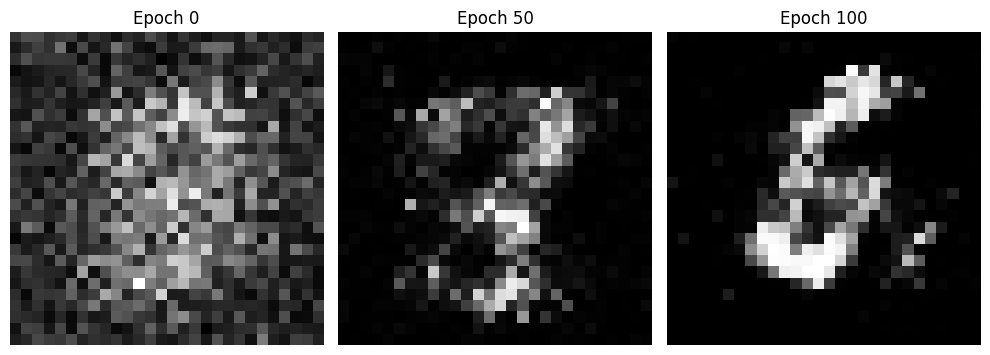

In [ ]:
# Plot sample imgaes at 0, 50, 100 epochs 
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(sample_images[0][0].squeeze(), cmap='gray')
plt.title("Epoch 0")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sample_images[50][0].squeeze(), cmap='gray')
plt.title("Epoch 50")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sample_images[100][0].squeeze(), cmap='gray')
plt.title("Epoch 100")
plt.axis('off')

plt.tight_layout()
plt.show()


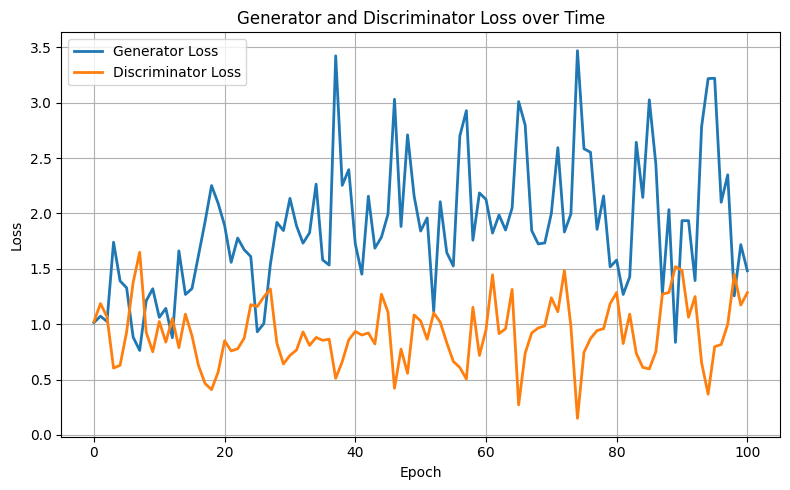

In [20]:
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(losses_G, label='Generator Loss', linewidth=2)
plt.plot(losses_D, label='Discriminator Loss', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
